In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [58]:
#v = 2
v = 1.8
dt = 0.01
num_st_pts = int(v/dt)
num_pts = 50

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
    
def straight(dist, curr_pose, n=num_st_pts):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    x0, y0, t0 = curr_pose
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    x = (xf - x0) * np.linspace(0, 1, n) + x0
    y = (yf - y0) * np.linspace(0, 1, n) + y0
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
    # adjust scaling constant for desired turn radius
     x0, y0, t0 = curr_pose
     theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
     x= x0 + np.cumsum(v*np.cos(theta)*dt)
     y= y0 + np.cumsum(v*np.sin(theta)*dt)
     return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt])
        
    return x, y, t

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

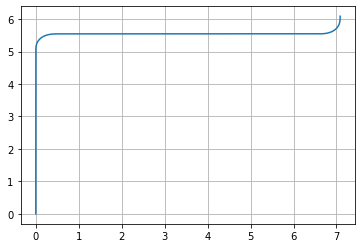

In [59]:
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
x, y, _ = generate_trajectory(route)
plt.figure()
plt.plot(x, y)
plt.grid()

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

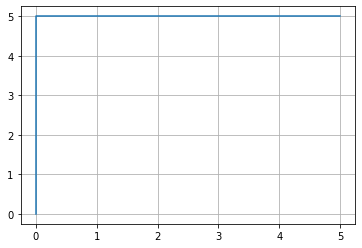

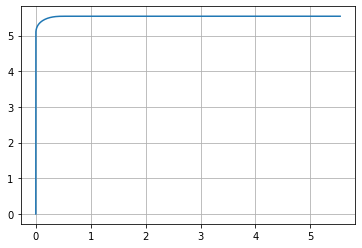

In [60]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 6, 6
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
y2 = [y1[-1]]*s2

x, y = x1[:-1]+x2, y1[:-1]+y2
plt.figure()
plt.plot(x, y)
plt.grid()

#find the corner point and plot it
corners = []
for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
  slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
  if np.abs(slope) > 0.0:
    corners.append([x2, y2])

# Fix a turn radius r
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
r = 1
s1, s2 = s1 -r, s2 - r

# use generate_trajectory() and plot the smooth path
route = [("straight", s1),("turn", -90),("straight", s2)]
x, y, _ = generate_trajectory(route)
plt.figure()
plt.plot(x, y)
plt.grid()

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

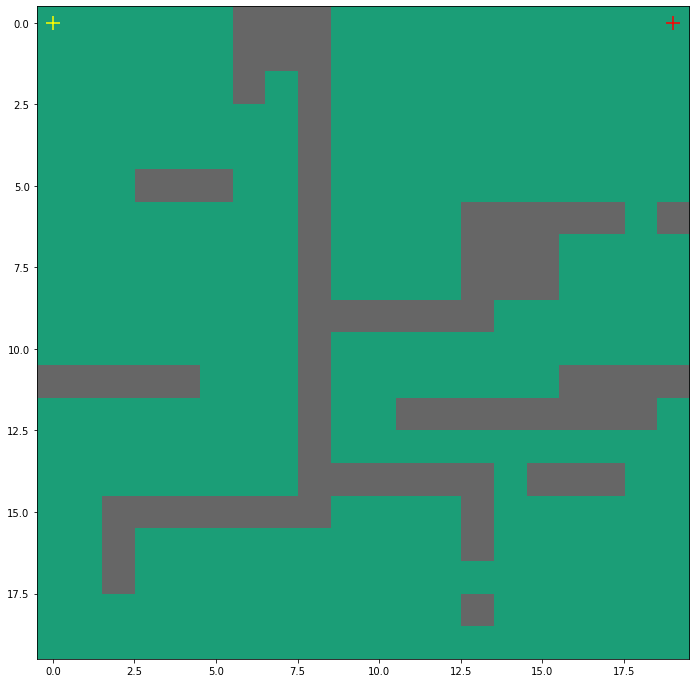

In [61]:
# use np.load to load a grid of 1s and 0s
# 1 - occupied 0- free
grid = np.load("/content/drive/MyDrive/Assignment LABLET AP102/Week 2/data/astar_grid.npy")
# you can define your own start/ end
start = (0, 0)
goal = (0, 19)

# visualize the start/ end and the robot's environment
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
plt.show()

In [45]:
#initialize graph
grid_size = grid.shape
G = nx.grid_2d_graph(*grid_size)
num_nodes = 0 # counter to keep track of deleted nodes
#loop to remove nodes
for i in range(20): 
  for j in range(20):
    if grid[i, j] == 1:
      G.remove_node((i, j))
      num_nodes +=1
print(f"removed {num_nodes} nodes")
print(f"number of occupied cells in grid {np.sum(grid)}")

removed 77 nodes
number of occupied cells in grid 77


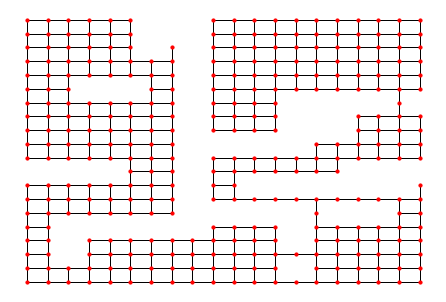

In [46]:
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, pos=pos, node_color='red', node_size=10) 

In [47]:
# write the Euclidean function that takes in the
# node x, y and compute the distance
def euclidean(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [48]:
#ost = np.ones(grid_size)
nx.set_edge_attributes(G,{e:1 for e in G.edges()}, "cost")
astar_path = nx.astar_path(G, start, goal, heuristic=euclidean, weight='cost')
print(astar_path)

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (9, 14), (9, 15), (9, 16), (8, 16), (7, 16), (7, 17), (7, 18), (6, 18), (5, 18), (4, 18), (3, 18), (2, 18), (1, 18), (0, 18), (0, 19)]


In [62]:
corners = []
commands = []
k = 0
for i in range(0,len(astar_path)-2):
  x1, y1 = astar_path[i]
  x2, y2 = astar_path[i+1]
  x3, y3 = astar_path[i+2]
  slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
  if slope>0.0:
    commands.append(('turn', 90))
  elif slope<0.0:
    commands.append(('turn', -90))
  else:
    commands.append(('straight', (euclidean((x1, y1), (x2, y2)))))
  if np.abs(slope) > 0.0:
    corners.append([x2, y2])
print(commands)
print(corners)

[('straight', 1.0), ('turn', -90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn', 90), ('straight', 1.0), ('straight', 1.0), ('turn', -90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn', -90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn', 90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn', 90), ('straight', 1.0), ('turn', 90), ('turn', -90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn', 90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn', 90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn', -90), ('straight', 1.0), ('straight', 1.0), ('turn', -90), ('straight', 1.0), ('straight', 1.0), ('straight', 1.0), ('turn',

[ 0.00000000e+00  3.42080111e-19  6.84160223e-19 ... -2.56385530e-01
 -2.56420377e-01 -2.56420377e-01]
[0.00000000e+00 5.58659218e-03 1.11731844e-02 ... 1.83913673e+01
 1.84093673e+01 1.84273673e+01]


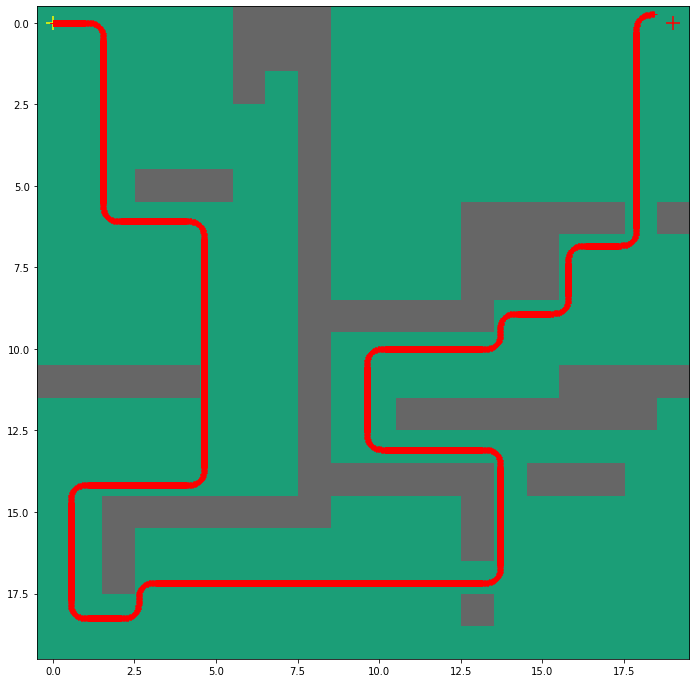

In [63]:
x, y, _ = generate_trajectory(commands)
print(x)
print(y)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
q = generate_trajectory(commands)
ax.plot(y, x,'r+')


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs